In [1]:
from utilities import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

In [2]:
dataset = load_dataset("Train")

Loaded 100 subjects


In [3]:
X,y = create_features_matrix(dataset, category=True)
print(f"Number of features: {X.shape[1]}")

Creating features matrix


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]

Number of features: 47


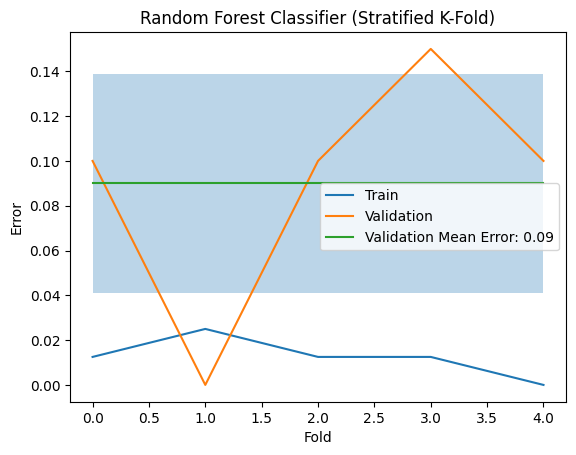

In [22]:
K = 5
N_ESTIMATORS = 100
MAX_DEPTH = 5
MAX_FEATURES = "log2"
MIN_SAMPLES_SPLIT = 10
MIN_SAMPLES_LEAF = 2

train_errors = []
val_errors = []

kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = RandomForestClassifier(
        n_estimators=N_ESTIMATORS, 
        max_depth=MAX_DEPTH, 
        max_features=MAX_FEATURES, 
        min_samples_split=MIN_SAMPLES_SPLIT, 
        min_samples_leaf=MIN_SAMPLES_LEAF, 
        random_state=0
    )
    
    model.fit(X_train, y_train)
    train_errors.append(1 - model.score(X_train, y_train))
    val_errors.append(1 - model.score(X_val, y_val))

mean_val_error = np.mean(val_errors)
std_val_error = np.std(val_errors)

# Plot des erreurs
fig = plt.figure()
plt.plot(range(K), train_errors, label="Train")
plt.plot(range(K), val_errors, label="Validation")
plt.plot(range(K), [mean_val_error] * K, label=f"Validation Mean Error: {mean_val_error:.2f}")
plt.fill_between(range(K), [mean_val_error - std_val_error] * K, [mean_val_error + std_val_error] * K, alpha=0.3)
plt.title("Random Forest Classifier (Stratified K-Fold)")
plt.xlabel("Fold")
plt.ylabel("Error")
plt.legend()
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 500, 1000],  # Nombre d'arbres
    'max_depth': [5, 10, 15],  # Profondeur max
    'max_features': ['sqrt', 'log2'],  # Nombre de features sélectionnées à chaque split
    'min_samples_split': [2, 5, 10],  # Min échantillons pour split un nœud
    'min_samples_leaf': [1, 2, 5]  # Min échantillons dans une feuille
}

# Cross-validation stratifiée pour garder un bon équilibre des classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modèle Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid Search avec Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1, verbose=1)

# Entraînement sur les données
grid_search.fit(X, y)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Score de validation :", grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Meilleurs hyperparamètres : {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Score de validation : 0.93


In [9]:
clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,max_features=MAX_FEATURES, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,random_state=0)
clf.fit(X, y)
print(clf.score(X, y))

0.99


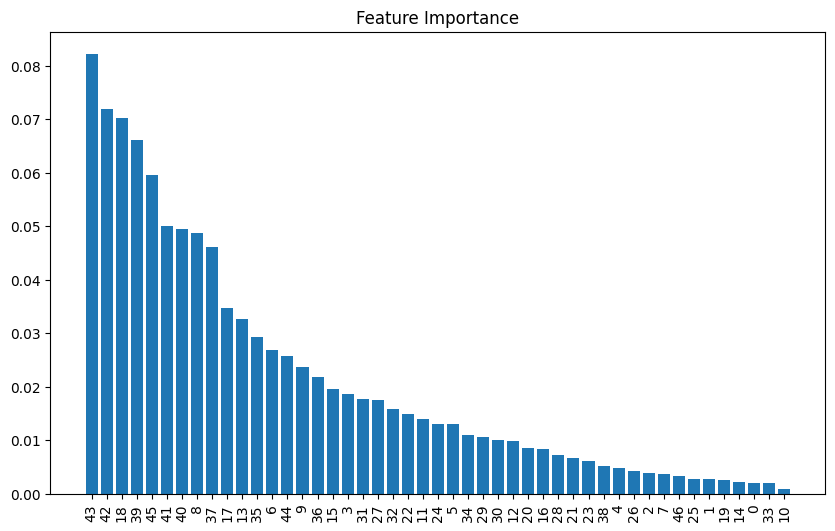

In [23]:
importances = clf.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

In [12]:
pca = PCA(n_components=6) 
X_pca = pca.fit_transform(X)

print(f"Var explained : {sum(pca.explained_variance_ratio_):.2f}")

Var explained : 1.00


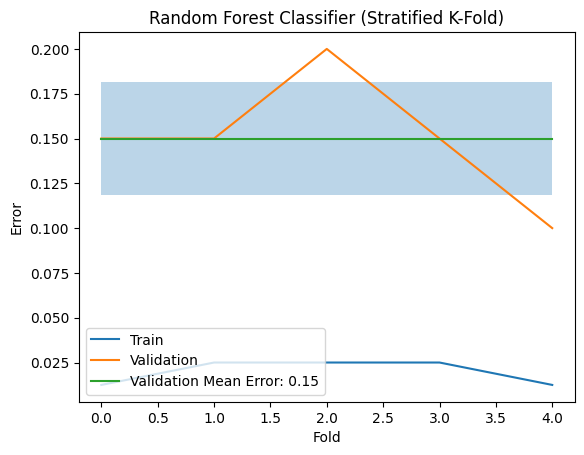

In [ ]:
train_errors = []
val_errors = []

kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)

for train_index, val_index in kf.split(X_pca, y):
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = RandomForestClassifier(
        n_estimators=N_ESTIMATORS, 
        max_depth=MAX_DEPTH, 
        max_features=MAX_FEATURES, 
        min_samples_split=MIN_SAMPLES_SPLIT, 
        min_samples_leaf=MIN_SAMPLES_LEAF, 
        random_state=0
    )
    
    model.fit(X_train, y_train)
    train_errors.append(1 - model.score(X_train, y_train))
    val_errors.append(1 - model.score(X_val, y_val))

mean_val_error = np.mean(val_errors)
std_val_error = np.std(val_errors)

fig = plt.figure()
plt.plot(range(K), train_errors, label="Train")
plt.plot(range(K), val_errors, label="Validation")
plt.plot(range(K), [mean_val_error] * K, label=f"Validation Mean Error: {mean_val_error:.2f}")
plt.fill_between(range(K), [mean_val_error - std_val_error] * K, [mean_val_error + std_val_error] * K, alpha=0.3)
plt.title("Random Forest Classifier (Stratified K-Fold)")
plt.xlabel("Fold")
plt.ylabel("Error")
plt.legend()
plt.show()

In [14]:
clf_pca = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,max_features=MAX_FEATURES, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,random_state=0)
clf_pca.fit(X_pca, y)
print(clf_pca.score(X_pca, y))

0.98


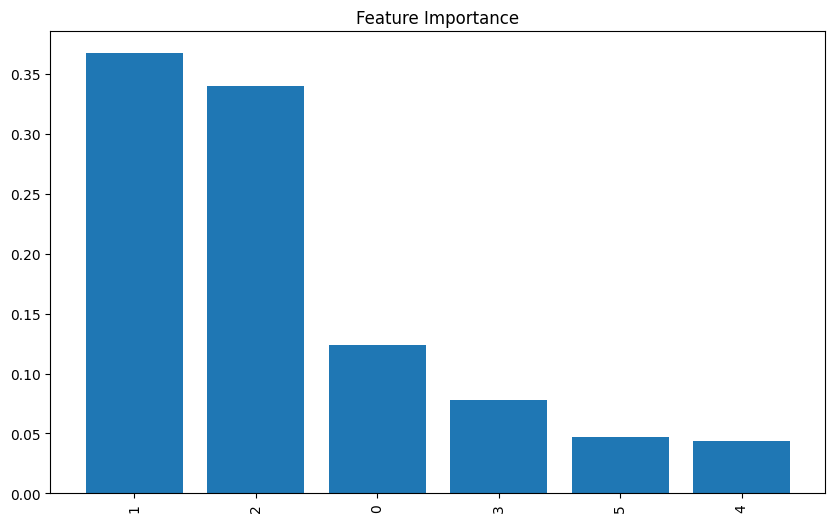

In [15]:
importances = clf_pca.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

Loaded 50 subjects
Creating features matrix


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


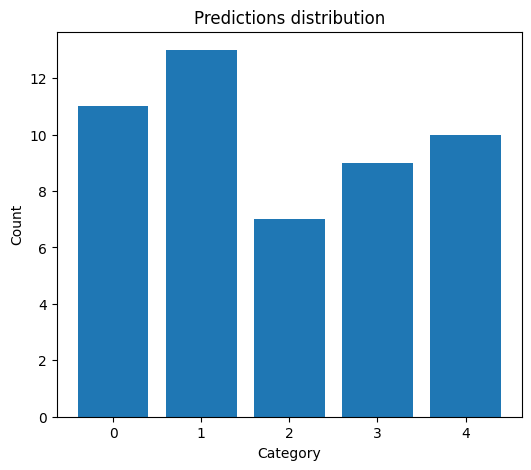

Submission file submission.csv created


In [24]:
submission(clf, "submission")

Loaded 50 subjects
Creating features matrix


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


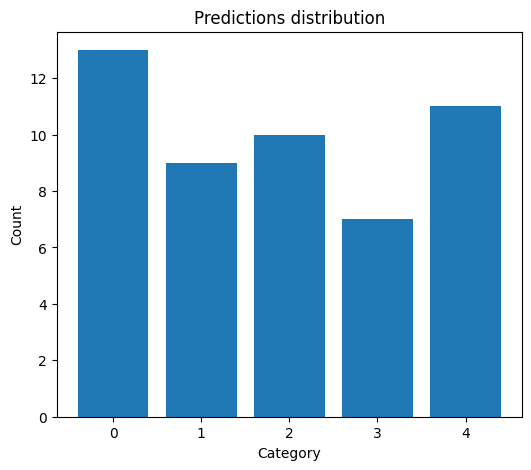

Submission file submission.csv created


In [16]:
submission(clf_pca, "submission", pca=pca)